# Method 7 - Best Ideas High Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] < qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

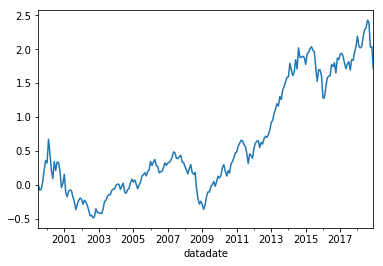

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.360181
2000-12-31   -0.248815
2001-12-31   -0.211199
2002-12-31   -0.267107
2003-12-31    0.592553
2004-12-31    0.151664
2005-12-31    0.125580
2006-12-31    0.056249
2007-12-31    0.032393
2008-12-31   -0.429646
2009-12-31    0.485785
2010-12-31    0.305712
2011-12-31   -0.052571
2012-12-31    0.296137
2013-12-31    0.432041
2014-12-31    0.111850
2015-12-31   -0.094361
2016-12-31    0.092593
2017-12-31    0.069337
2018-12-31   -0.109313
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     359.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.72e-97
Time:                        22:41:59   Log-Likelihood:                 519.06
No. Observations:                 234   AIC:                            -1028.
Df Residuals:                     229   BIC:                            -1011.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.749      0.082      -0.000       0.007
mktrf          0.9736      0.050     19.615      0.000       0.876       1.071
me             0.6351      0.058     10.999      0.000       0.521       0.749
ia            -0.4297      0.088     -4.897      0.000      -0.603      -0.257
roe           -0.5148      0.075     -6.853      0.000      -0.663      -0.367
==============================================================================
Omnibus:                       32.799   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.723
Skew:                           0.575   Prob(JB):                     4.45e-21
Kurtosis:                       5.879   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     209.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.68e-75
Time:                        22:41:59   Log-Likelihood:                 519.06
No. Observations:                 234   AIC:                            -1028.
Df Residuals:                     229   BIC:                            -1011.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.814      0.070      -0.000       0.007
mktrf          0.9736      0.060     16.154      0.000       0.855       1.092
me             0.6351      0.094      6.743      0.000       0.450       0.820
ia            -0.4297      0.131     -3.270      0.001      -0.687      -0.172
roe           -0.5148      0.113     -4.570      0.000      -0.736      -0.294
==============================================================================
Omnibus:                       32.799   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.723
Skew:                           0.575   Prob(JB):                     4.45e-21
Kurtosis:                       5.879   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     224.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.13e-78
Time:                        22:41:59   Log-Likelihood:                 519.06
No. Observations:                 234   AIC:                            -1028.
Df Residuals:                     229   BIC:                            -1011.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.782      0.075      -0.000       0.007
mktrf          0.9736      0.059     16.499      0.000       0.858       1.089
me             0.6351      0.095      6.682      0.000       0.449       0.821
ia            -0.4297      0.142     -3.020      0.003      -0.709      -0.151
roe           -0.5148      0.113     -4.543      0.000      -0.737      -0.293
==============================================================================
Omnibus:                       32.799   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.723
Skew:                           0.575   Prob(JB):                     4.45e-21
Kurtosis:                       5.879   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     368.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.96e-107
Time:                        22:41:59   Log-Likelihood:                 544.74
No. Observations:                 234   AIC:                            -1077.
Df Residuals:                     228   BIC:                            -1057.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.918      0.056   -8.66e-05       0.006
mktrf          1.0288      0.045     23.035      0.000       0.941       1.117
smb            0.6258      0.059     10.620      0.000       0.510       0.742
hml           -0.2858      0.069     -4.113      0.000      -0.423      -0.149
rmw           -0.5753      0.079     -7.322      0.000      -0.730      -0.420
cma            0.0650      0.100      0.650      0.516      -0.132       0.262
==============================================================================
Omnibus:                       11.068   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               18.531
Skew:                           0.250   Prob(JB):                     9.46e-05
Kurtosis:                       4.285   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     567.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.71e-126
Time:                        22:41:59   Log-Likelihood:                 544.74
No. Observations:                 234   AIC:                            -1077.
Df Residuals:                     228   BIC:                            -1057.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.148      0.032       0.000       0.006
mktrf          1.0288      0.050     20.599      0.000       0.931       1.127
smb            0.6258      0.054     11.678      0.000       0.521       0.731
hml           -0.2858      0.088     -3.235      0.001      -0.459      -0.113
rmw           -0.5753      0.083     -6.930      0.000      -0.738      -0.413
cma            0.0650      0.120      0.543      0.587      -0.169       0.299
==============================================================================
Omnibus:                       11.068   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               18.531
Skew:                           0.250   Prob(JB):                     9.46e-05
Kurtosis:                       4.285   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     522.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.02e-122
Time:                        22:41:59   Log-Likelihood:                 544.74
No. Observations:                 234   AIC:                            -1077.
Df Residuals:                     228   BIC:                            -1057.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.990      0.047    4.74e-05       0.006
mktrf          1.0288      0.053     19.293      0.000       0.924       1.133
smb            0.6258      0.049     12.738      0.000       0.530       0.722
hml           -0.2858      0.078     -3.649      0.000      -0.439      -0.132
rmw           -0.5753      0.086     -6.698      0.000      -0.744      -0.407
cma            0.0650      0.119      0.544      0.586      -0.169       0.299
==============================================================================
Omnibus:                       11.068   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               18.531
Skew:                           0.250   Prob(JB):                     9.46e-05
Kurtosis:                       4.285   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     380.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.12e-100
Time:                        22:41:59   Log-Likelihood:                 524.54
No. Observations:                 234   AIC:                            -1039.
Df Residuals:                     229   BIC:                            -1022.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.471      0.638      -0.003       0.004
mktrf          1.1301      0.045     25.315      0.000       1.042       1.218
smb            0.8350      0.056     14.984      0.000       0.725       0.945
hml           -0.3142      0.055     -5.676      0.000      -0.423      -0.205
umd           -0.0877      0.036     -2.416      0.016      -0.159      -0.016
==============================================================================
Omnibus:                       34.183   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.443
Skew:                           0.708   Prob(JB):                     1.13e-16
Kurtosis:                       5.351   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     332.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.92e-94
Time:                        22:41:59   Log-Likelihood:                 524.54
No. Observations:                 234   AIC:                            -1039.
Df Residuals:                     229   BIC:                            -1022.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.550      0.582      -0.002       0.004
mktrf          1.1301      0.046     24.450      0.000       1.040       1.221
smb            0.8350      0.072     11.645      0.000       0.694       0.976
hml           -0.3142      0.054     -5.870      0.000      -0.419      -0.209
umd           -0.0877      0.051     -1.716      0.086      -0.188       0.012
==============================================================================
Omnibus:                       34.183   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.443
Skew:                           0.708   Prob(JB):                     1.13e-16
Kurtosis:                       5.351   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     277.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.63e-86
Time:                        22:41:59   Log-Likelihood:                 524.54
No. Observations:                 234   AIC:                            -1039.
Df Residuals:                     229   BIC:                            -1022.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.553      0.580      -0.002       0.004
mktrf          1.1301      0.050     22.605      0.000       1.032       1.228
smb            0.8350      0.064     13.129      0.000       0.710       0.960
hml           -0.3142      0.049     -6.409      0.000      -0.410      -0.218
umd           -0.0877      0.056     -1.573      0.116      -0.197       0.022
==============================================================================
Omnibus:                       34.183   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.443
Skew:                           0.708   Prob(JB):                     1.13e-16
Kurtosis:                       5.351   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     185.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.01e-49
Time:                        22:41:59   Log-Likelihood:                 243.24
No. Observations:                 120   AIC:                            -476.5
Df Residuals:                     115   BIC:                            -462.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.246      0.215      -0.002       0.010
mktrf          1.0102      0.084     12.036      0.000       0.844       1.176
me             0.7190      0.083      8.674      0.000       0.555       0.883
ia            -0.5153      0.130     -3.970      0.000      -0.772      -0.258
roe           -0.4607      0.115     -4.010      0.000      -0.688      -0.233
==============================================================================
Omnibus:                       18.881   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.742
Skew:                           0.729   Prob(JB):                     2.11e-07
Kurtosis:                       5.006   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     237.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-54
Time:                        22:41:59   Log-Likelihood:                 243.24
No. Observations:                 120   AIC:                            -476.5
Df Residuals:                     115   BIC:                            -462.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.431      0.152      -0.001       0.009
mktrf          1.0102      0.115      8.773      0.000       0.784       1.236
me             0.7190      0.107      6.743      0.000       0.510       0.928
ia            -0.5153      0.172     -2.991      0.003      -0.853      -0.178
roe           -0.4607      0.173     -2.659      0.008      -0.800      -0.121
==============================================================================
Omnibus:                       18.881   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.742
Skew:                           0.729   Prob(JB):                     2.11e-07
Kurtosis:                       5.006   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     301.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.90e-60
Time:                        22:41:59   Log-Likelihood:                 243.24
No. Observations:                 120   AIC:                            -476.5
Df Residuals:                     115   BIC:                            -462.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      1.564      0.118      -0.001       0.009
mktrf          1.0102      0.122      8.264      0.000       0.771       1.250
me             0.7190      0.109      6.581      0.000       0.505       0.933
ia            -0.5153      0.175     -2.950      0.003      -0.858      -0.173
roe           -0.4607      0.177     -2.599      0.009      -0.808      -0.113
==============================================================================
Omnibus:                       18.881   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.742
Skew:                           0.729   Prob(JB):                     2.11e-07
Kurtosis:                       5.006   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     213.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.41e-56
Time:                        22:41:59   Log-Likelihood:                 263.26
No. Observations:                 120   AIC:                            -514.5
Df Residuals:                     114   BIC:                            -497.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.003      2.161      0.033       0.000       0.011
mktrf          1.0931      0.075     14.531      0.000       0.944       1.242
smb            0.6960      0.085      8.169      0.000       0.527       0.865
hml           -0.3201      0.104     -3.066      0.003      -0.527      -0.113
rmw           -0.5131      0.123     -4.167      0.000      -0.757      -0.269
cma            0.0518      0.135      0.384      0.702      -0.215       0.319
==============================================================================
Omnibus:                        4.692   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                5.247
Skew:                           0.216   Prob(JB):                       0.0726
Kurtosis:                       3.929   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     761.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.69e-86
Time:                        22:41:59   Log-Likelihood:                 263.26
No. Observations:                 120   AIC:                            -514.5
Df Residuals:                     114   BIC:                            -497.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      3.192      0.001       0.002       0.009
mktrf          1.0931      0.082     13.374      0.000       0.933       1.253
smb            0.6960      0.070      9.976      0.000       0.559       0.833
hml           -0.3201      0.145     -2.211      0.027      -0.604      -0.036
rmw           -0.5131      0.151     -3.400      0.001      -0.809      -0.217
cma            0.0518      0.148      0.349      0.727      -0.239       0.343
==============================================================================
Omnibus:                        4.692   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                5.247
Skew:                           0.216   Prob(JB):                       0.0726
Kurtosis:                       3.929   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     988.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.39e-92
Time:                        22:41:59   Log-Likelihood:                 263.26
No. Observations:                 120   AIC:                            -514.5
Df Residuals:                     114   BIC:                            -497.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      3.833      0.000       0.003       0.009
mktrf          1.0931      0.090     12.180      0.000       0.917       1.269
smb            0.6960      0.065     10.713      0.000       0.569       0.823
hml           -0.3201      0.134     -2.381      0.017      -0.584      -0.057
rmw           -0.5131      0.162     -3.161      0.002      -0.831      -0.195
cma            0.0518      0.144      0.360      0.719      -0.230       0.334
==============================================================================
Omnibus:                        4.692   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                5.247
Skew:                           0.216   Prob(JB):                       0.0726
Kurtosis:                       3.929   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     229.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.73e-54
Time:                        22:41:59   Log-Likelihood:                 254.47
No. Observations:                 120   AIC:                            -498.9
Df Residuals:                     115   BIC:                            -485.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.171      0.244      -0.002       0.009
mktrf          1.2275      0.067     18.231      0.000       1.094       1.361
smb            0.8765      0.077     11.434      0.000       0.725       1.028
hml           -0.3358      0.077     -4.374      0.000      -0.488      -0.184
umd           -0.0573      0.047     -1.210      0.229      -0.151       0.036
==============================================================================
Omnibus:                       21.511   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.629
Skew:                           0.849   Prob(JB):                     4.98e-08
Kurtosis:                       4.960   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     531.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.83e-73
Time:                        22:41:59   Log-Likelihood:                 254.47
No. Observations:                 120   AIC:                            -498.9
Df Residuals:                     115   BIC:                            -485.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.742      0.082      -0.000       0.007
mktrf          1.2275      0.058     21.273      0.000       1.114       1.341
smb            0.8765      0.083     10.622      0.000       0.715       1.038
hml           -0.3358      0.068     -4.966      0.000      -0.468      -0.203
umd           -0.0573      0.055     -1.044      0.296      -0.165       0.050
==============================================================================
Omnibus:                       21.511   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.629
Skew:                           0.849   Prob(JB):                     4.98e-08
Kurtosis:                       4.960   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     606.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.94e-76
Time:                        22:41:59   Log-Likelihood:                 254.47
No. Observations:                 120   AIC:                            -498.9
Df Residuals:                     115   BIC:                            -485.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      2.135      0.033       0.000       0.006
mktrf          1.2275      0.060     20.607      0.000       1.111       1.344
smb            0.8765      0.068     12.936      0.000       0.744       1.009
hml           -0.3358      0.054     -6.189      0.000      -0.442      -0.229
umd           -0.0573      0.058     -0.987      0.324      -0.171       0.056
==============================================================================
Omnibus:                       21.511   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.629
Skew:                           0.849   Prob(JB):                     4.98e-08
Kurtosis:                       4.960   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     202.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.82e-49
Time:                        22:41:59   Log-Likelihood:                 303.96
No. Observations:                 114   AIC:                            -597.9
Df Residuals:                     109   BIC:                            -584.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.986      0.326      -0.002       0.005
mktrf          0.9898      0.051     19.573      0.000       0.890       1.090
me             0.3878      0.078      4.967      0.000       0.233       0.543
ia            -0.1362      0.108     -1.257      0.211      -0.351       0.078
roe           -0.4799      0.095     -5.043      0.000      -0.668      -0.291
==============================================================================
Omnibus:                       10.944   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               21.770
Skew:                           0.313   Prob(JB):                     1.87e-05
Kurtosis:                       5.047   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     518.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.34e-70
Time:                        22:41:59   Log-Likelihood:                 303.96
No. Observations:                 114   AIC:                            -597.9
Df Residuals:                     109   BIC:                            -584.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.923      0.356      -0.002       0.005
mktrf          0.9898      0.042     23.353      0.000       0.907       1.073
me             0.3878      0.061      6.394      0.000       0.269       0.507
ia            -0.1362      0.173     -0.785      0.432      -0.476       0.204
roe           -0.4799      0.087     -5.515      0.000      -0.650      -0.309
==============================================================================
Omnibus:                       10.944   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               21.770
Skew:                           0.313   Prob(JB):                     1.87e-05
Kurtosis:                       5.047   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     705.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.71e-77
Time:                        22:41:59   Log-Likelihood:                 303.96
No. Observations:                 114   AIC:                            -597.9
Df Residuals:                     109   BIC:                            -584.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.777      0.437      -0.003       0.006
mktrf          0.9898      0.047     20.895      0.000       0.897       1.083
me             0.3878      0.063      6.124      0.000       0.264       0.512
ia            -0.1362      0.196     -0.693      0.488      -0.521       0.249
roe           -0.4799      0.090     -5.359      0.000      -0.655      -0.304
==============================================================================
Omnibus:                       10.944   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               21.770
Skew:                           0.313   Prob(JB):                     1.87e-05
Kurtosis:                       5.047   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     143.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.75e-46
Time:                        22:41:59   Log-Likelihood:                 298.51
No. Observations:                 114   AIC:                            -585.0
Df Residuals:                     108   BIC:                            -568.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.085      0.933      -0.004       0.003
mktrf          1.0149      0.051     19.970      0.000       0.914       1.116
smb            0.4663      0.083      5.652      0.000       0.303       0.630
hml           -0.1988      0.105     -1.889      0.062      -0.407       0.010
rmw           -0.4285      0.129     -3.326      0.001      -0.684      -0.173
cma            0.1558      0.164      0.953      0.343      -0.168       0.480
==============================================================================
Omnibus:                        7.568   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               11.056
Skew:                           0.281   Prob(JB):                      0.00397
Kurtosis:                       4.419   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     272.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.68e-59
Time:                        22:41:59   Log-Likelihood:                 298.51
No. Observations:                 114   AIC:                            -585.0
Df Residuals:                     108   BIC:                            -568.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.077      0.938      -0.004       0.004
mktrf          1.0149      0.053     19.204      0.000       0.911       1.118
smb            0.4663      0.063      7.458      0.000       0.344       0.589
hml           -0.1988      0.066     -3.033      0.002      -0.327      -0.070
rmw           -0.4285      0.114     -3.769      0.000      -0.651      -0.206
cma            0.1558      0.193      0.807      0.420      -0.223       0.534
==============================================================================
Omnibus:                        7.568   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               11.056
Skew:                           0.281   Prob(JB):                      0.00397
Kurtosis:                       4.419   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     550.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.36e-75
Time:                        22:41:59   Log-Likelihood:                 298.51
No. Observations:                 114   AIC:                            -585.0
Df Residuals:                     108   BIC:                            -568.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.066      0.947      -0.005       0.004
mktrf          1.0149      0.059     17.167      0.000       0.899       1.131
smb            0.4663      0.067      6.910      0.000       0.334       0.599
hml           -0.1988      0.059     -3.357      0.001      -0.315      -0.083
rmw           -0.4285      0.111     -3.851      0.000      -0.647      -0.210
cma            0.1558      0.233      0.669      0.504      -0.301       0.612
==============================================================================
Omnibus:                        7.568   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               11.056
Skew:                           0.281   Prob(JB):                      0.00397
Kurtosis:                       4.419   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     163.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.91e-45
Time:                        22:41:59   Log-Likelihood:                 293.51
No. Observations:                 114   AIC:                            -577.0
Df Residuals:                     109   BIC:                            -563.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.250      0.803      -0.004       0.003
mktrf          1.0320      0.053     19.648      0.000       0.928       1.136
smb            0.5603      0.082      6.841      0.000       0.398       0.723
hml           -0.0858      0.084     -1.018      0.311      -0.253       0.081
umd           -0.1031      0.064     -1.621      0.108      -0.229       0.023
==============================================================================
Omnibus:                        7.285   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.026   Jarque-Bera (JB):               11.868
Skew:                           0.194   Prob(JB):                      0.00265
Kurtosis:                       4.532   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     223.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-51
Time:                        22:41:59   Log-Likelihood:                 293.51
No. Observations:                 114   AIC:                            -577.0
Df Residuals:                     109   BIC:                            -563.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.231      0.818      -0.004       0.004
mktrf          1.0320      0.052     19.964      0.000       0.931       1.133
smb            0.5603      0.063      8.862      0.000       0.436       0.684
hml           -0.0858      0.087     -0.983      0.326      -0.257       0.085
umd           -0.1031      0.055     -1.873      0.061      -0.211       0.005
==============================================================================
Omnibus:                        7.285   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.026   Jarque-Bera (JB):               11.868
Skew:                           0.194   Prob(JB):                      0.00265
Kurtosis:                       4.532   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     274.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.32e-56
Time:                        22:41:59   Log-Likelihood:                 293.51
No. Observations:                 114   AIC:                            -577.0
Df Residuals:                     109   BIC:                            -563.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.204      0.838      -0.005       0.004
mktrf          1.0320      0.056     18.537      0.000       0.923       1.141
smb            0.5603      0.054     10.440      0.000       0.455       0.665
hml           -0.0858      0.072     -1.190      0.234      -0.227       0.056
umd           -0.1031      0.051     -2.014      0.044      -0.204      -0.003
==============================================================================
Omnibus:                        7.285   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.026   Jarque-Bera (JB):               11.868
Skew:                           0.194   Prob(JB):                      0.00265
Kurtosis:                       4.532   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""